# Reverse Image Search

From an image, search for similar images in a dataset of images

---



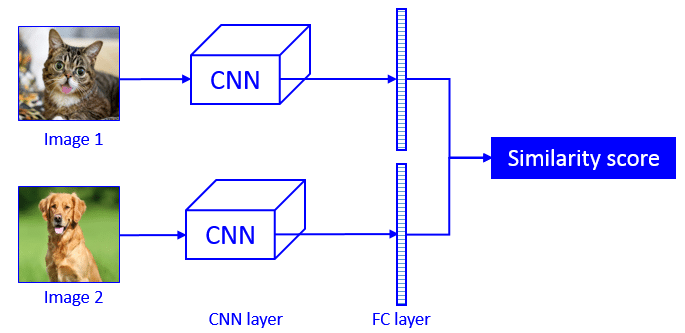

#Imports, Installations and Initialisation

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import pickle
import os
import itertools
import random
import bz2


from tensorflow.keras.applications import ResNet50


%mkdir vectors

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
!cp -ar /content/drive/MyDrive/imagenet_resized.zip .
!unzip imagenet_resized.zip

In [ ]:
!cp -ar /content/drive/MyDrive/vectors .

^C


#Load Pre-trained Resnet50 model

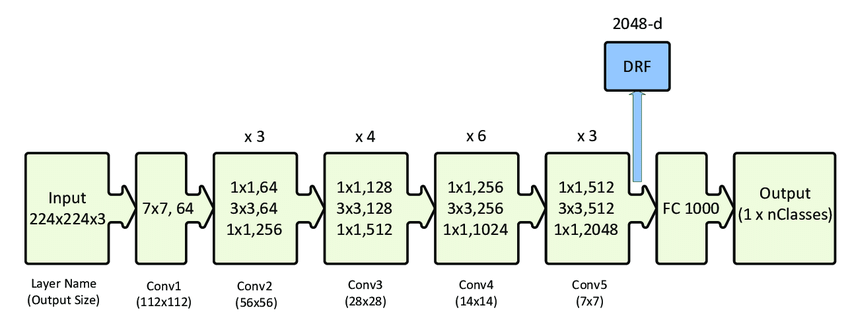

In [ ]:
model = ResNet50(input_shape=(224, 224,3), include_top = False, weights="imagenet")

94773248/94765736 [==============================] - 0s 0us/step


#Main Helper Functions

In [ ]:
def get_vector(image, model):
    predictions = model.predict(np.asarray([image]))
    predictions = predictions.flatten()
    return predictions


def save_vectors_dataset(filelist, dataset_directory, model, vector_directory = '/content/vectors/'):
    
    
    count = 0  
    for filename in filelist:
        count+=1
        print(filename, " -- ", count)
        if isinstance(filename, str) :
            img = cv2.imread(dataset_directory + '/' + filename)
            dict = {filename: get_vector(img, model)}
            
            with bz2.BZ2File(vector_directory + str(count) + '.pbz2',"w") as f:  
            # with open(vector_directory + str(count) + '.pickle',"wb") as f:  
                pickle.dump(dict, f)
        else:
            filelist.remove(filename)




In [ ]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

def get_similar_images(image, filelist, dataset_directory, model, vector_directory = '/content/vectors/', n = 9):
    vector = get_vector(image, model)
    result_images = []
    scores = []
    filenames = []
    vectors_filelist= [filename for filename in os.listdir(vector_directory) if filename.endswith('.pbz2')]
    random.shuffle(vectors_filelist)
    count = 0
    for vector_file in vectors_filelist:
        count+=1
        # print(vector_file, " -- ", count)
        if count>10000:
            break
        with bz2.BZ2File(vector_directory+vector_file,"r") as f:  
        # with open(vector_directory + '/' + vector_file,"rb") as f:    
            dict = pickle.load(f)
            filename = list(dict.keys())[0]
            curr_vec = dict[filename]
            similarity = cosine_similarity(curr_vec, vector)
            if similarity>0.9:
                if np.sum(np.abs(curr_vec - vector)) == 0:
                    continue

            scores.append(similarity)
            filenames.append(filename)

    n = 9
    indices = np.argpartition(np.asarray(scores), -n)[-n:]
    best_scores = np.asarray(scores)[indices]
    best_files = np.asarray(filenames)[indices]
    indices = np.argsort(-best_scores)
    if (len(indices)!= n):
        print(len(indices))
        return []
    for i in indices:
        img = cv2.imread(dataset_directory + '/' + best_files[i])
        result_images.append(img)

    return result_images


def get_images_grid(querry_img, images, padding = 10):
    w = np.int(np.ceil(np.sqrt(len(images))))
    h = w

    while (len(images)<w*h):
        images.append(255*np.ones(images[0].shape))
    img_h, img_w, img_c = images[0].shape

    m_x = padding
    m_y = padding

    mat_x = img_w * w + m_x * (w + 1)
    mat_y = img_h * h + m_y * (h + 1)

    imgmatrix = np.zeros((mat_y, mat_x, img_c),np.uint8)
    imgmatrix.fill(255)

    positions = itertools.product(range(h), range(w))

    for (y_i, x_i), img in zip(positions, images):
        x = x_i * (img_w + m_x) + m_x
        y = y_i * (img_h + m_y) + m_y
        imgmatrix[y:y+img_h, x:x+img_w, :] = img

    # imgmatrix = cv2.cvtColor(imgmatrix, cv2.COLOR_RGB2BGR)
    image_size = images[0].shape[0]
    final_img = 255*np.ones((imgmatrix.shape[0] + image_size + padding, imgmatrix.shape[1], imgmatrix.shape[2]))
    starting_x = final_img.shape[1]//2 - image_size//2
    final_img[padding:padding + image_size, starting_x:starting_x+image_size, :] = querry_img
    final_img[image_size+padding:, :, :] = imgmatrix
    return final_img

#Main Inference Function

In [ ]:
def reverse_image_search(image, model = model, dataset_directory = 'dataset', vector_directory = '/content/vectors/', save_path = 'reverse_search.png', threshold = 0.15, generate = False, padding = 10):
    filelist= [filename for filename in os.listdir(dataset_directory) if filename.endswith('.jpg')]
    filelist.append([filename for filename in os.listdir(dataset_directory) if filename.endswith('.png')])

    random.shuffle(filelist)
    if generate:
        save_vectors_dataset(filelist, dataset_directory, model, vector_directory)
        print("Vector files generated... starting reverse search")
        print("=========")

    result_images = get_similar_images(image, filelist, dataset_directory, model, vector_directory, threshold)
    # print(len(result_images))
    if(len(result_images) != 0 ):
        final_image = get_images_grid(image, result_images, padding)

        cv2.imwrite(save_path, final_image)

#Inference Examples

In [ ]:
img = cv2.imread('/content/imagenet_resized/0001_000026.jpg')
import random
import bz2
reverse_image_search(img, dataset_directory = '/content/imagenet_resized', save_path = 'reverse_search2.png', generate = False, threshold = 0.4)

In [ ]:
%mkdir results
%time
count = 0 
filelist= [filename for filename in os.listdir('/content/imagenet_resized') if filename.endswith('.jpg')]
random.shuffle(filelist)
for filename in filelist:
    print(count)
    count+=1
    if count >=100:
        break
    img = cv2.imread('/content/imagenet_resized/' + filename)
    reverse_image_search(img, dataset_directory = '/content/imagenet_resized', save_path = 'results/reverse_search_' + str(count) +'.png', generate = False, threshold = 0.4)


mkdir: cannot create directory ‘results’: File exists
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
